In [53]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os

from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical 
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from keras.layers import Dense, Dropout 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Flatten, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
import datetime

# Create a dataset

In [36]:
batch_size = 32
img_height = 224
img_width = 224

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\tmp\Gano-Cat-Breeds-V1_1",
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5625 files belonging to 15 classes.
Using 4500 files for training.


In [38]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\tmp\Gano-Cat-Breeds-V1_1",
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5625 files belonging to 15 classes.
Using 1125 files for validation.


In [39]:
class_names = train_ds.class_names
print(class_names)

['Abyssinian', 'American Bobtail', 'American Shorthair', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx', 'Tuxedo']


# Visualize the data

In [40]:
"""t.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    print(labels[i])
    plt.title(class_names[labels[i]==1][0].title())
    plt.axis("off")"""

't.figure(figsize=(10, 10))\nfor images, labels in train_ds.take(1):\n  for i in range(9):\n    ax = plt.subplot(3, 3, i + 1)\n    plt.imshow(images[i].numpy().astype("uint8"))\n    print(labels[i])\n    plt.title(class_names[labels[i]==1][0].title())\n    plt.axis("off")'

In [41]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 15)


# Configure the dataset for performance

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

In [43]:
IMG_SIZE = (224, 224)
# Create the base model from the pre-trained model MobileNet V3
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               weights='imagenet')

In [44]:
base_model.trainable = False

In [45]:
len(base_model.trainable_variables) # Shows that its frozen

0

In [46]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                   

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_85 (ReLU)                (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_85[0][0]']               
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_90 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_90[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 a)                                                                                               
                                                                                                  
 multiply_46 (Multiply)         (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_65[0][0]']    
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_46[0][0]']            
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_69 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_102 (ReLU)               (None, 14, 14, 184)  0           ['tf.__operators__.add_69[0][0]']
                                                                                                  
 tf.math.multiply_69 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_102[0][0]']              
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_52[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_72[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_76 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_109 (ReLU)               (None, 14, 14, 672)  0           ['tf.__operators__.add_76[0][0]']
                                                                                                  
 tf.math.multiply_76 (TFOpLambd  (None, 14, 14, 672)  0          ['re_lu_109[0][0]']              
 a)                                                                                               
          

                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_57[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_80 (TFOpL  (None, 7, 7, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_113

 tf.math.multiply_83 (TFOpLambd  (None, 7, 7, 960)   0           ['re_lu_116[0][0]']              
 a)                                                                                               
                                                                                                  
 multiply_60 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_83[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_60[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

Total params: 5,507,432
Trainable params: 0
Non-trainable params: 5,507,432
__________________________________________________________________________________________________


In [47]:
#setup input shape into the model
INPUT_SHAPE = [None,IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

#setup output shape of our model
OUTPUT_SHAPE = len(class_names)



# Setup Layers
model = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer   
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer       
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 4 (Output Layer)       
])


# Compiling the model
base_learning_rate = 0.0001
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      metrics =["accuracy"]
)

# Build Model
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 1000)             5507432   
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 512)               512512    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 15)                3855      
                                                      

# Initial Run

In [48]:
loss0, accuracy0 = model.evaluate(val_ds)

36/36 [==============================] - 20s 524ms/step - loss: 2.7039 - accuracy: 0.1218


In [49]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.70
initial accuracy: 0.12


In [57]:
import datetime

def create_model_checkpoint(dir, suffix=None):
    modeldir = os.path.join(dir, "Models",
                            datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
    
    model_path = modeldir + "-" + suffix
    print(f"Model will be saved to `{model_path}`")
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy',save_best_only=True)

In [58]:
# EPOCHS
initial_epochs = 40

# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "cats_classifier")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Model Training
model_history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    validation_freq=1,
                    callbacks=[early_stopping, checkpoint]
                )

Model will be saved to `Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier`
Epoch 1/40
141/141 [==============================] - ETA: 0s - loss: 2.6313 - accuracy: 0.2651

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 119s 799ms/step - loss: 2.6313 - accuracy: 0.2651 - val_loss: 2.5231 - val_accuracy: 0.2738
Epoch 2/40
141/141 [==============================] - ETA: 0s - loss: 2.3482 - accuracy: 0.3031

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 105s 745ms/step - loss: 2.3482 - accuracy: 0.3031 - val_loss: 2.1701 - val_accuracy: 0.2907
Epoch 3/40
141/141 [==============================] - ETA: 0s - loss: 2.0492 - accuracy: 0.3331

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 113s 802ms/step - loss: 2.0492 - accuracy: 0.3331 - val_loss: 1.9283 - val_accuracy: 0.3387
Epoch 4/40
141/141 [==============================] - ETA: 0s - loss: 1.8758 - accuracy: 0.3691

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 115s 819ms/step - loss: 1.8758 - accuracy: 0.3691 - val_loss: 1.7966 - val_accuracy: 0.3876
Epoch 5/40
141/141 [==============================] - ETA: 0s - loss: 1.7800 - accuracy: 0.3931

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 118s 836ms/step - loss: 1.7800 - accuracy: 0.3931 - val_loss: 1.7140 - val_accuracy: 0.4160
Epoch 6/40
141/141 [==============================] - ETA: 0s - loss: 1.7251 - accuracy: 0.4073

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 94s 671ms/step - loss: 1.7251 - accuracy: 0.4073 - val_loss: 1.6627 - val_accuracy: 0.4373
Epoch 7/40
141/141 [==============================] - ETA: 0s - loss: 1.6820 - accuracy: 0.4202

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 95s 672ms/step - loss: 1.6820 - accuracy: 0.4202 - val_loss: 1.6216 - val_accuracy: 0.4560
Epoch 8/40
141/141 [==============================] - 77s 545ms/step - loss: 1.6493 - accuracy: 0.4298 - val_loss: 1.5920 - val_accuracy: 0.4551
Epoch 9/40
141/141 [==============================] - ETA: 0s - loss: 1.6327 - accuracy: 0.4320

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 101s 715ms/step - loss: 1.6327 - accuracy: 0.4320 - val_loss: 1.5705 - val_accuracy: 0.4649
Epoch 10/40
141/141 [==============================] - ETA: 0s - loss: 1.5990 - accuracy: 0.4544

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 102s 727ms/step - loss: 1.5990 - accuracy: 0.4544 - val_loss: 1.5485 - val_accuracy: 0.4693
Epoch 11/40
141/141 [==============================] - ETA: 0s - loss: 1.5905 - accuracy: 0.4500

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 97s 690ms/step - loss: 1.5905 - accuracy: 0.4500 - val_loss: 1.5279 - val_accuracy: 0.4764
Epoch 12/40
141/141 [==============================] - ETA: 0s - loss: 1.5748 - accuracy: 0.4560

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 104s 743ms/step - loss: 1.5748 - accuracy: 0.4560 - val_loss: 1.5115 - val_accuracy: 0.4916
Epoch 13/40
141/141 [==============================] - ETA: 0s - loss: 1.5684 - accuracy: 0.4578

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 106s 751ms/step - loss: 1.5684 - accuracy: 0.4578 - val_loss: 1.4936 - val_accuracy: 0.4987
Epoch 14/40
141/141 [==============================] - 90s 636ms/step - loss: 1.5454 - accuracy: 0.4582 - val_loss: 1.4823 - val_accuracy: 0.4951
Epoch 15/40
141/141 [==============================] - ETA: 0s - loss: 1.5282 - accuracy: 0.4624

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 106s 756ms/step - loss: 1.5282 - accuracy: 0.4624 - val_loss: 1.4612 - val_accuracy: 0.5120
Epoch 16/40
141/141 [==============================] - 90s 636ms/step - loss: 1.5063 - accuracy: 0.4722 - val_loss: 1.4549 - val_accuracy: 0.5040
Epoch 17/40
141/141 [==============================] - 91s 645ms/step - loss: 1.5001 - accuracy: 0.4820 - val_loss: 1.4371 - val_accuracy: 0.5111
Epoch 18/40
141/141 [==============================] - 91s 648ms/step - loss: 1.4821 - accuracy: 0.4924 - val_loss: 1.4243 - val_accuracy: 0.5111
Epoch 19/40
141/141 [==============================] - ETA: 0s - loss: 1.4641 - accuracy: 0.4858

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 108s 771ms/step - loss: 1.4641 - accuracy: 0.4858 - val_loss: 1.4071 - val_accuracy: 0.5280
Epoch 20/40
141/141 [==============================] - 86s 613ms/step - loss: 1.4571 - accuracy: 0.4964 - val_loss: 1.3995 - val_accuracy: 0.5191
Epoch 21/40
141/141 [==============================] - ETA: 0s - loss: 1.4483 - accuracy: 0.5033

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 107s 761ms/step - loss: 1.4483 - accuracy: 0.5033 - val_loss: 1.3873 - val_accuracy: 0.5316
Epoch 22/40
141/141 [==============================] - 89s 631ms/step - loss: 1.4347 - accuracy: 0.4973 - val_loss: 1.3782 - val_accuracy: 0.5262
Epoch 23/40
141/141 [==============================] - 90s 640ms/step - loss: 1.4219 - accuracy: 0.4996 - val_loss: 1.3666 - val_accuracy: 0.5307
Epoch 24/40
141/141 [==============================] - 87s 620ms/step - loss: 1.4051 - accuracy: 0.5140 - val_loss: 1.3602 - val_accuracy: 0.5316
Epoch 25/40
141/141 [==============================] - 93s 661ms/step - loss: 1.3913 - accuracy: 0.5198 - val_loss: 1.3500 - val_accuracy: 0.5262
Epoch 26/40
141/141 [==============================] - 84s 597ms/step - loss: 1.3852 - accuracy: 0.5229 - val_loss: 1.3403 - val_accuracy: 0.5316
Epoch 27/40
141/141 [==============================] - ETA: 0s - loss: 1.3703 - accuracy: 0.5276

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 105s 750ms/step - loss: 1.3703 - accuracy: 0.5276 - val_loss: 1.3373 - val_accuracy: 0.5396
Epoch 28/40
141/141 [==============================] - ETA: 0s - loss: 1.3777 - accuracy: 0.5251

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 105s 746ms/step - loss: 1.3777 - accuracy: 0.5251 - val_loss: 1.3263 - val_accuracy: 0.5440
Epoch 29/40
141/141 [==============================] - 86s 610ms/step - loss: 1.3499 - accuracy: 0.5302 - val_loss: 1.3194 - val_accuracy: 0.5404
Epoch 30/40
141/141 [==============================] - ETA: 0s - loss: 1.3479 - accuracy: 0.5369

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 106s 750ms/step - loss: 1.3479 - accuracy: 0.5369 - val_loss: 1.3111 - val_accuracy: 0.5449
Epoch 31/40
141/141 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.5282

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 106s 755ms/step - loss: 1.3383 - accuracy: 0.5282 - val_loss: 1.3019 - val_accuracy: 0.5467
Epoch 32/40
141/141 [==============================] - 88s 625ms/step - loss: 1.3223 - accuracy: 0.5409 - val_loss: 1.2932 - val_accuracy: 0.5422
Epoch 33/40
141/141 [==============================] - 85s 600ms/step - loss: 1.3164 - accuracy: 0.5507 - val_loss: 1.2907 - val_accuracy: 0.5431
Epoch 34/40
141/141 [==============================] - 86s 611ms/step - loss: 1.3054 - accuracy: 0.5489 - val_loss: 1.2900 - val_accuracy: 0.5458
Epoch 35/40
141/141 [==============================] - ETA: 0s - loss: 1.3004 - accuracy: 0.5509

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 106s 753ms/step - loss: 1.3004 - accuracy: 0.5509 - val_loss: 1.2763 - val_accuracy: 0.5644
Epoch 36/40
141/141 [==============================] - 88s 624ms/step - loss: 1.3092 - accuracy: 0.5533 - val_loss: 1.2690 - val_accuracy: 0.5636
Epoch 37/40
141/141 [==============================] - 89s 634ms/step - loss: 1.2909 - accuracy: 0.5553 - val_loss: 1.2633 - val_accuracy: 0.5573
Epoch 38/40
141/141 [==============================] - 92s 654ms/step - loss: 1.2777 - accuracy: 0.5558 - val_loss: 1.2573 - val_accuracy: 0.5582
Epoch 39/40
141/141 [==============================] - 93s 657ms/step - loss: 1.2799 - accuracy: 0.5576 - val_loss: 1.2483 - val_accuracy: 0.5644
Epoch 40/40
141/141 [==============================] - ETA: 0s - loss: 1.2706 - accuracy: 0.5562

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets



141/141 [==============================] - 112s 798ms/step - loss: 1.2706 - accuracy: 0.5562 - val_loss: 1.2393 - val_accuracy: 0.5689


 # Model Learning Curves (Accuracy/Loss)

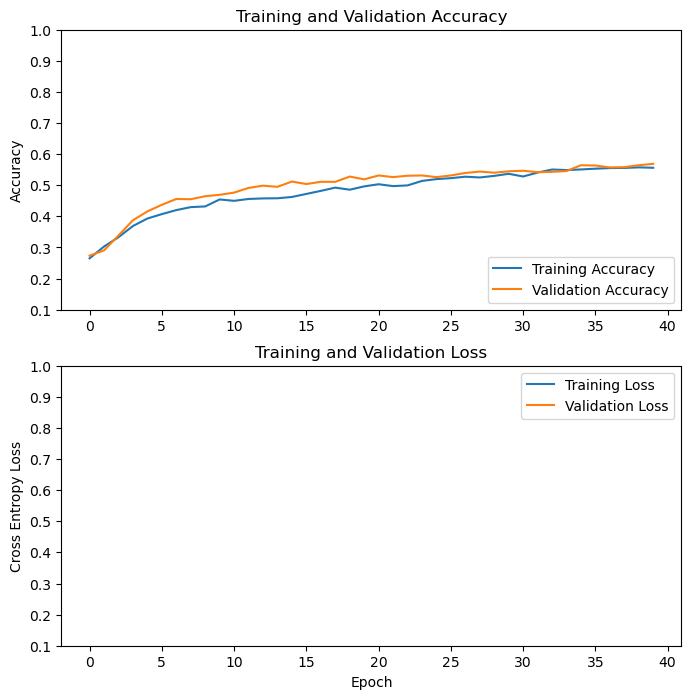

In [85]:
def plot_learning_curves(model_history):
    # retrieve learning metrics history 
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss =model_history.history['val_loss']

    # Plot
    fig = plt.figure(figsize=(8,8))
    ax_acc = plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel("Accuracy")
    plt.ylim([0.1, 1])
    plt.title("Training and Validation Accuracy",)
    
    ax_loss = plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy Loss')
    plt.ylim([0.1,1])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_learning_curves(model_history)

# Fine Tuning

In [60]:
base_model.trainable = True

In [61]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  273


In [62]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
      metrics =["accuracy"]
)

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 1000)             5507432   
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 512)               512512    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 15)                3855      
                                                      

In [66]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=model_history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[early_stopping, checkpoint])

Epoch 40/60
141/141 [==============================] - 166s 1s/step - loss: 1.2813 - accuracy: 0.5647 - val_loss: 1.4622 - val_accuracy: 0.5093
Epoch 41/60
141/141 [==============================] - ETA: 0s - loss: 1.0998 - accuracy: 0.6289

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 189s 1s/step - loss: 1.0998 - accuracy: 0.6289 - val_loss: 1.2320 - val_accuracy: 0.5867
Epoch 42/60
141/141 [==============================] - ETA: 0s - loss: 0.9797 - accuracy: 0.6707

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 205s 1s/step - loss: 0.9797 - accuracy: 0.6707 - val_loss: 1.0545 - val_accuracy: 0.6436
Epoch 43/60
141/141 [==============================] - ETA: 0s - loss: 0.9011 - accuracy: 0.6909

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 207s 1s/step - loss: 0.9011 - accuracy: 0.6909 - val_loss: 0.9627 - val_accuracy: 0.6756
Epoch 44/60
141/141 [==============================] - ETA: 0s - loss: 0.8204 - accuracy: 0.7191

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 208s 1s/step - loss: 0.8204 - accuracy: 0.7191 - val_loss: 0.8959 - val_accuracy: 0.7004
Epoch 45/60
141/141 [==============================] - ETA: 0s - loss: 0.7718 - accuracy: 0.7400

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 218s 2s/step - loss: 0.7718 - accuracy: 0.7400 - val_loss: 0.8566 - val_accuracy: 0.7049
Epoch 46/60
141/141 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7596

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 221s 2s/step - loss: 0.7123 - accuracy: 0.7596 - val_loss: 0.8260 - val_accuracy: 0.7200
Epoch 47/60
141/141 [==============================] - 204s 1s/step - loss: 0.6716 - accuracy: 0.7767 - val_loss: 0.7942 - val_accuracy: 0.7147
Epoch 48/60
141/141 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.7909

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 223s 2s/step - loss: 0.6262 - accuracy: 0.7909 - val_loss: 0.7822 - val_accuracy: 0.7218
Epoch 49/60
141/141 [==============================] - ETA: 0s - loss: 0.5881 - accuracy: 0.8129

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 227s 2s/step - loss: 0.5881 - accuracy: 0.8129 - val_loss: 0.7689 - val_accuracy: 0.7307
Epoch 50/60
141/141 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.8256

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 217s 2s/step - loss: 0.5459 - accuracy: 0.8256 - val_loss: 0.7588 - val_accuracy: 0.7422
Epoch 51/60
141/141 [==============================] - 180s 1s/step - loss: 0.5068 - accuracy: 0.8396 - val_loss: 0.7569 - val_accuracy: 0.7404
Epoch 52/60
141/141 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.8533

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 199s 1s/step - loss: 0.4839 - accuracy: 0.8533 - val_loss: 0.7513 - val_accuracy: 0.7484
Epoch 53/60
141/141 [==============================] - ETA: 0s - loss: 0.4503 - accuracy: 0.8624

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 202s 1s/step - loss: 0.4503 - accuracy: 0.8624 - val_loss: 0.7462 - val_accuracy: 0.7538
Epoch 54/60
141/141 [==============================] - 183s 1s/step - loss: 0.4186 - accuracy: 0.8709 - val_loss: 0.7404 - val_accuracy: 0.7538
Epoch 55/60
141/141 [==============================] - 184s 1s/step - loss: 0.3910 - accuracy: 0.8758 - val_loss: 0.7384 - val_accuracy: 0.7511
Epoch 56/60
141/141 [==============================] - 200s 1s/step - loss: 0.3708 - accuracy: 0.8878 - val_loss: 0.7324 - val_accuracy: 0.7529
Epoch 57/60
141/141 [==============================] - 212s 2s/step - loss: 0.3449 - accuracy: 0.8989 - val_loss: 0.7362 - val_accuracy: 0.7538
Epoch 58/60
141/141 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8971

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 235s 2s/step - loss: 0.3294 - accuracy: 0.8971 - val_loss: 0.7351 - val_accuracy: 0.7556
Epoch 59/60
141/141 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.9120

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


141/141 [==============================] - 228s 2s/step - loss: 0.3036 - accuracy: 0.9120 - val_loss: 0.7333 - val_accuracy: 0.7582
Epoch 60/60
141/141 [==============================] - ETA: 0s - loss: 0.2868 - accuracy: 0.9140

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_03-13_01_36-cats_classifier\assets



141/141 [==============================] - 231s 2s/step - loss: 0.2868 - accuracy: 0.9140 - val_loss: 0.7484 - val_accuracy: 0.7618


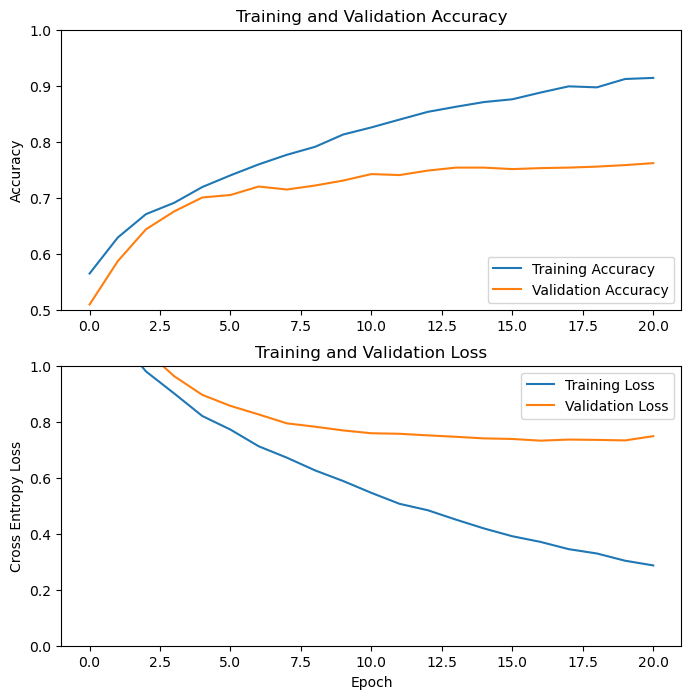

In [67]:
plot_learning_curves(history_fine)

In [70]:
model.save('Cats_Breeds1.h5')

In [68]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(class_names):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [69]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
def download_and_predict(filename):
    
    """test_image_array = img_to_array(test_image)
    new_image = tf.expand_dims(test_image_array,0)
    predicted_batch = model.predict(new_image)
    """
    # download and save
    img = image.load_img(filename, target_size=(224, 224))
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    #img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

1/1 [==============================] - 0s 67ms/step
36.97% 	 American Shorthair
29.02% 	 Bengal
16.92% 	 American Bobtail
9.82% 	 Egyptian Mau
4.31% 	 Abyssinian


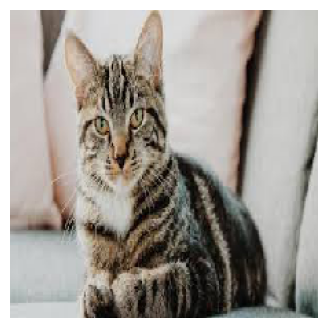

In [82]:
download_and_predict("cat7.jpeg")